<a href="https://colab.research.google.com/github/harishjungshahi/Deep-Learning/blob/main/Transfer_Learning_CalTech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Harish Practise: Transfer Learning CalTech

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
from google.colab import files
uploaded = files.upload()

Saving 101_ObjectCategories.tar.gz to 101_ObjectCategories.tar.gz


In [9]:
import tarfile

with tarfile.open("101_ObjectCategories.tar.gz", "r:gz") as tar:
    tar.extractall("caltech101")

## Load Caltech101 Dataset

In [10]:
transform = transforms.Compose([
    transforms.Resize((128,128)), #Resize Image to a Fixed Size
    transforms.RandomHorizontalFlip(), #Randomly flip images Horizontaly
    transforms.RandomRotation(10),     #Randomly rotates images
    transforms.ToTensor(),             #Convert Images to Pytorch Tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])     # Normalize to range [-1,-1]
])

# Load the entire Datasets
dataset = datasets.ImageFolder(root="caltech101/101_ObjectCategories", transform=transform)


In [11]:
len(dataset)

9144

In [12]:
dataset.classes

['BACKGROUND_Google',
 'Faces',
 'Faces_easy',
 'Leopards',
 'Motorbikes',
 'accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooste

In [13]:
# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset)) #80% for training
test_size = len(dataset) - train_size # 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

len(train_dataset), len(test_dataset)

(7315, 1829)

In [14]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualize a Few Images

In [15]:
for i, (images, labels) in enumerate(train_loader):
  print(images.shape)
  print(labels.shape)
  break

torch.Size([32, 3, 128, 128])
torch.Size([32])


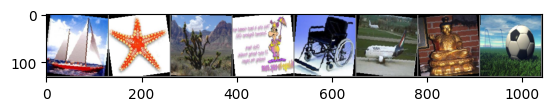

In [16]:
import torchvision

def imshow(img):
  img = img / 2 + 0.5 #UnNormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

# show images
imshow(torchvision.utils.make_grid(images[:8]))

In [17]:
labels[:8]

tensor([56, 87, 54,  0, 97,  6, 16, 85])

In [18]:
[dataset.classes[i] for i in labels[:8]]

['ketch',
 'starfish',
 'joshua_tree',
 'BACKGROUND_Google',
 'wheelchair',
 'airplanes',
 'buddha',
 'soccer_ball']

### Model Training Without Transfer Learning

In [19]:
class CNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), padding="same"), # Output(32,128,128)
        nn.ReLU(),
        nn.MaxPool2d(stride=(2,2), kernel_size=(2,2)), #Output(32,64,64)

        nn.Conv2d(32, 64, kernel_size=(3, 3), padding="same"), #Output (64,64,64)
        nn.ReLU(),
        nn.MaxPool2d(stride=(2,2), kernel_size=(2,2)), #Output(64,32,32)

        nn.Flatten(),
        nn.Linear(64 * 32 * 32, 256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128, num_classes)

        )
  def forward(self, x):
    return self.network(x)

In [20]:
# Training Loop
def train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5):
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [21]:
# Initialize model, loss function, and optimizer
num_classes = len(dataset.classes)
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5)

Epoch [1/5], Loss: 3.3816
Epoch [2/5], Loss: 2.4816
Epoch [3/5], Loss: 2.0098
Epoch [4/5], Loss: 1.6624
Epoch [5/5], Loss: 1.4254


In [22]:
def test_model(model, test_loader):
  # Evaluation Loop
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f"Test Accuracy: {100 * correct / total:.2f}%")

test_model(model,test_loader)

Test Accuracy: 51.72%


### Model Training With Transfer Learning

In [23]:
num_classes

102

### ResNet 18

In [24]:
from torchvision import models

# Load pre-trained ResNet18 model
model = models.resnet18(weights='DEFAULT')

# Replace the fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to device
model = model.to(device)

# Define Loss Function and Optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5)
test_model(model, test_loader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


Epoch [1/5], Loss: 2.0484
Epoch [2/5], Loss: 1.0867
Epoch [3/5], Loss: 0.7528
Epoch [4/5], Loss: 0.5945
Epoch [5/5], Loss: 0.4928
Test Accuracy: 71.57%


### EfficientNet

In [25]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5)
test_model(model, test_loader)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 54.3MB/s]


Epoch [1/5], Loss: 1.4627
Epoch [2/5], Loss: 0.5307
Epoch [3/5], Loss: 0.3433
Epoch [4/5], Loss: 0.2477
Epoch [5/5], Loss: 0.2044
Test Accuracy: 88.24%
